In [1]:
from utils import *

### Initialize the number of single stars and binaries to evolve

In [2]:
single_samples = 1000
binary_samples = 1000

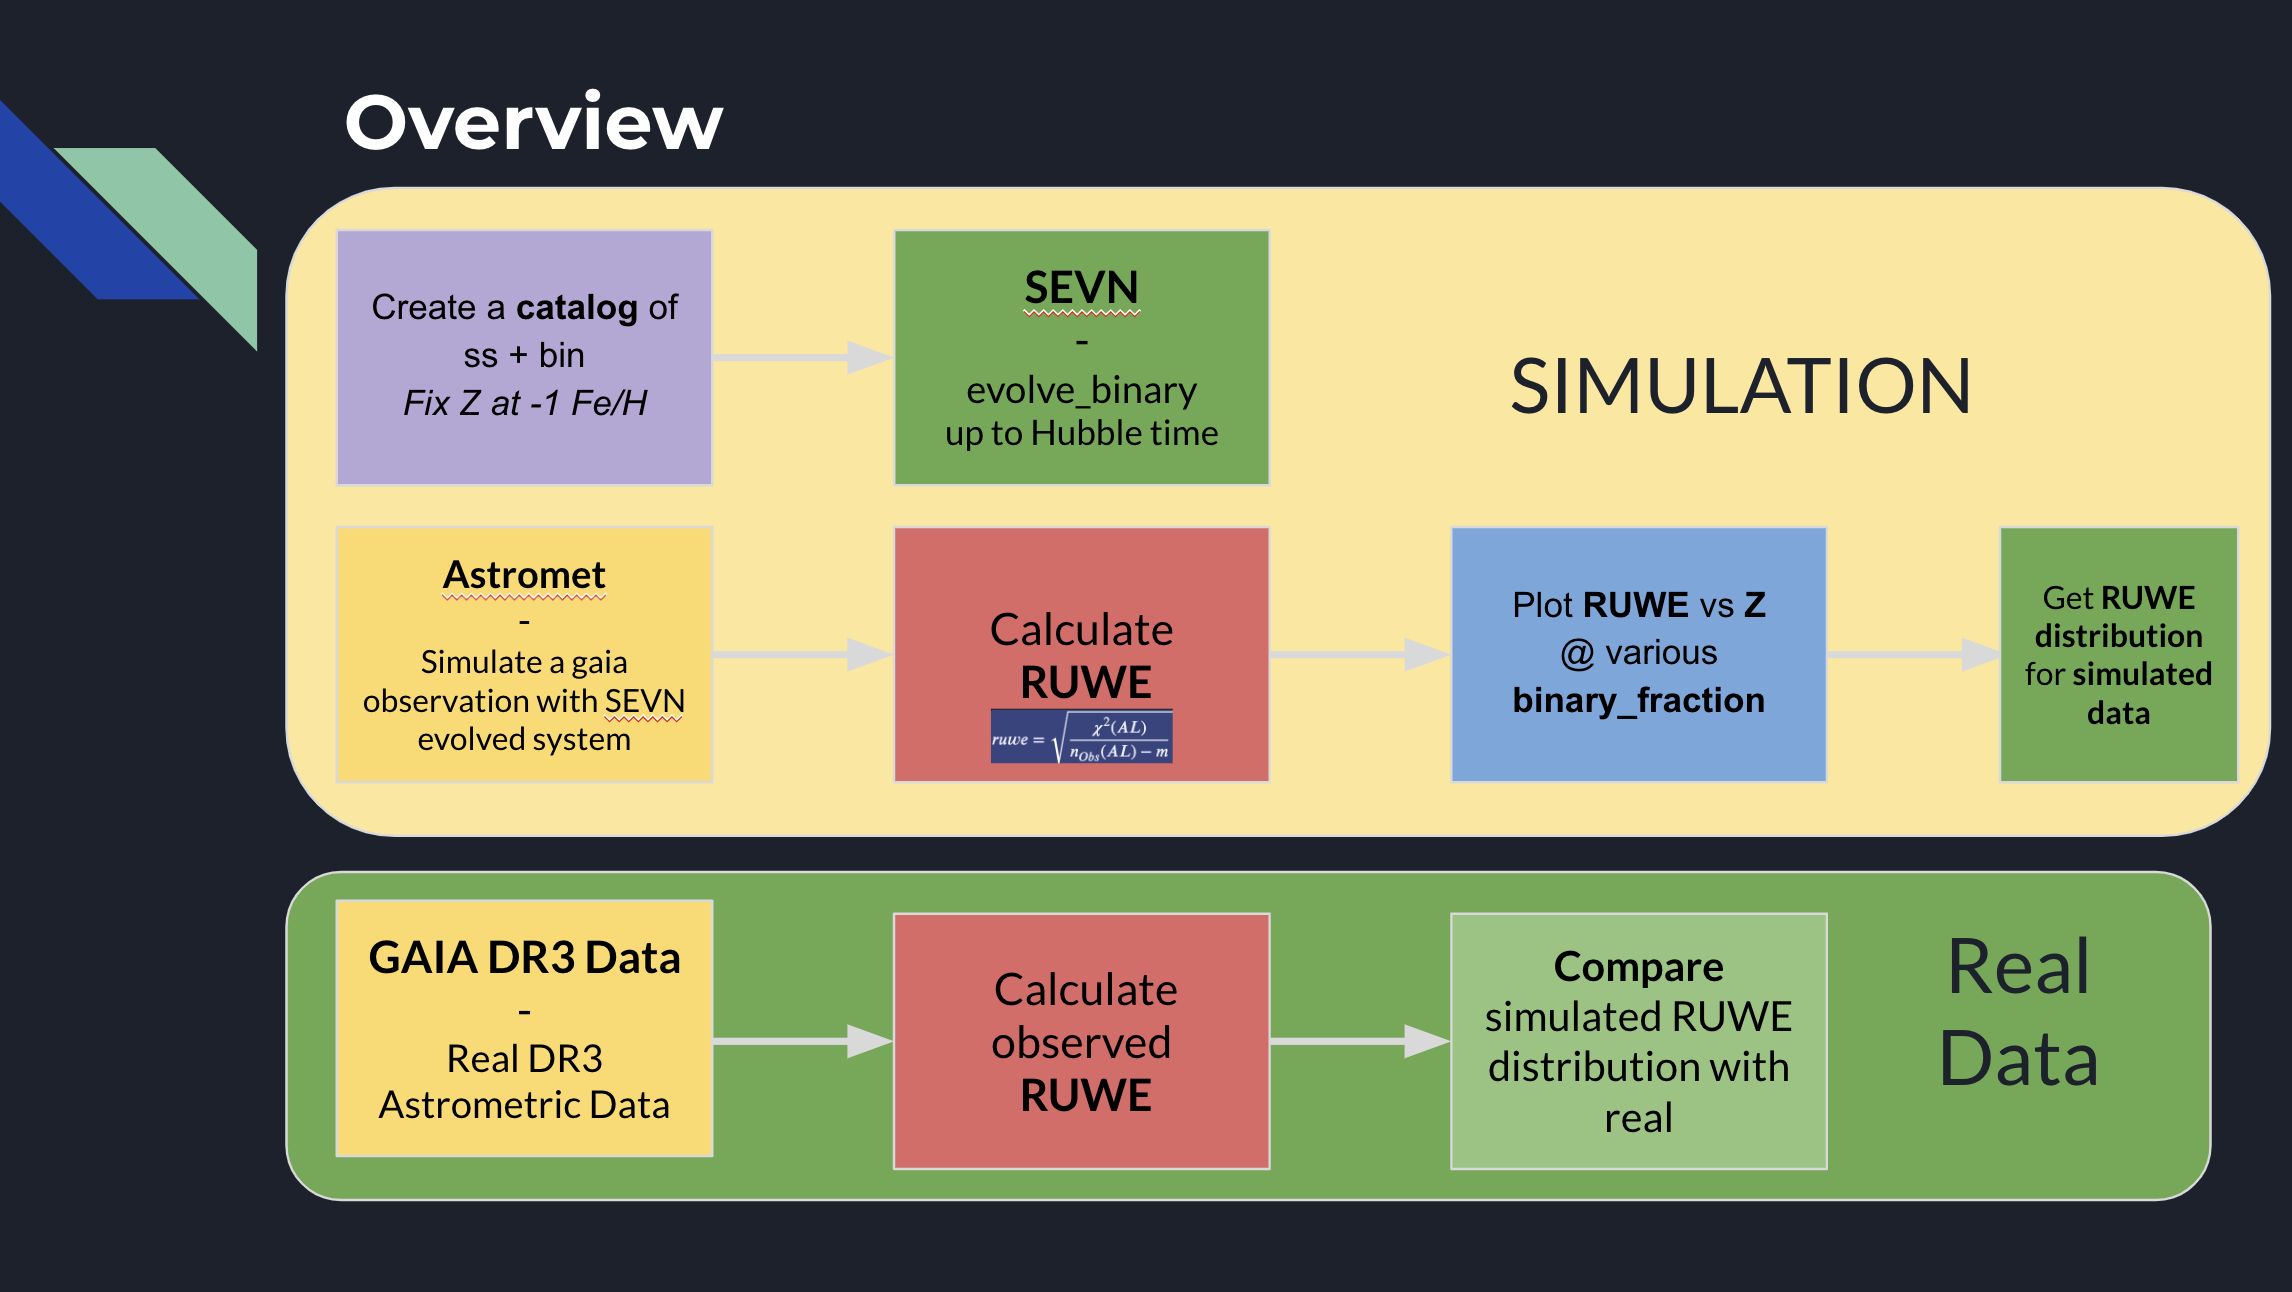

In [3]:
# Display an image from a local file with specified size
img_path = 'images/popsynth.png'
display(Image(filename=img_path, width=1000, height=800))  # Adjust width and height as needed

# Metallicity calculation:

$\frac{[Fe]}{[He]} = \log_{10}\left(\frac{Z}{Z_0}\right)$

where $Z_0 = 0.014$

Fix $\frac{[Fe]}{[He]} = -1$, which corresponds to $ Z = 0.0014$

### **IC4 package**

IC4popsyn is a python module developed for generating the IC for stellar population-synthesis studies. 

In paricular, IC4popsyn includes some of the most used state-of-the-art models (e.g Sana+12) and implements the possibility to generate the IC in the format used by our population synthesis codes (i.e. MOBSE and SEVN).


#### **Default parameters**:
- **alphas**: list of power-law slopes for the initial mass function
- **mass_ranges**: list of mass ranges for the initial mass function
- **logP_min**: minimum logarithm of the period
- **logP_max**: maximum logarithm of the period
- **logP_slope**: slope of the period distribution
- **e_min**: minimum eccentricity
- **e_max**: maximum eccentricity
- **e_slope**: slope of the eccentricity distribution
- **q_min**: minimum mass ratio
- **q_max**: maximum mass ratio
- **q_slope**: slope of the mass ratio distribution
- **mass_min**: minimum mass
- **mass_min_policy**: policy for minimum mass ("qmin" or "mmin")


## Sampling of Binary Star Properties

In the `Binaries` class, the properties of binary stars are sampled as follows:

- **Primary Mass \( m_1 \)**: Drawn from an Initial Mass Function (IMF), reflecting the distribution of star masses.
- **Secondary Mass \( m_2 \)**: Determined by a mass ratio \( q \) (where \( q = m_2/m_1 \)), sampled from a power law distribution, ensuring \( m_2 \) meets specified limits.
- **Orbital Period \( p \)**: Sampled using a power law distribution over a defined range of logarithmic periods, resulting in realistic orbital periods.
- **Eccentricity \( e \)**: Sampled from a power law distribution between defined minimum and maximum values.
- **Semi-Major Axis \( a \)**: Derived from the period \( p \) using Kepler's laws, linking the period and masses to the separation.

### Power Law Definition

A power law describes a relationship where one quantity varies as a power of another, expressed as \( y = kx^n \), where \( k \) is a constant, \( x \) is the variable, and \( n \) is the exponent. This distribution is often used to characterize the frequency of occurrences across various values, such as masses and orbital periods.


A **broken power-law** for the Initial Mass Function (IMF) is a piecewise-defined function where the slope of the power law changes at certain mass thresholds

$\xi(m)$ =

 \begin{cases}
m^{-1.3}, & \text{if } 0.08 \leq m < 0.5 M_\odot \\
m^{-2.3}, & \text{if } 0.5 \leq m < 1 M_\odot \\
m^{-2.3}, & \text{if } m \geq 1 M_\odot
\end{cases}

### **Simulate Nbin binaries with IC4popsyn**

In [4]:
binaries = ic_pop_synth(Nbin=single_samples, backup=1, z=0.0014, system_type=False, mass_ranges=[5, 150], 
            alphas=[-2.3], q_max=3.0, mass_min=5, model='sana12', period_units='yr')
singles = ic_pop_synth(Nbin=binary_samples, backup=1, z=0.0014, system_type=True, mass_ranges=[2.3, 150],
            alphas=[-2.3], mass_min=2.3, model='sana12', period_units='yr')

/ |#                                                  | 0 Elapsed Time: 0:00:00
| |#                                                 | 83 Elapsed Time: 0:00:00
/ |#                                                  | 0 Elapsed Time: 0:00:00
| |#                                                  | 0 Elapsed Time: 0:00:00


Building a population of binaries based on Sana+2012 and Kroupa2001
Building a population of binaries based on Sana+2012 and Kroupa2001

Single population print to file only supported for SEVN input style.
Please consider to turn single_pop argument to True.



### **Convert IC files from .in to csvs**

In [5]:
z = 0.0014
system_type = "binary"
ic_binary = process_binary_population(z, system_type)

z = 0.0014
system_type = "single"
ic_single = process_binary_population(z, system_type)


Conversion successful! Saved as ic4_binary_0.0014.csv
Conversion successful! Saved as ic4_single_0.0014.csv


### **Evolve Binaries with SEVN**

In [6]:
evolved_binaries = run_sevn_simulations(ic_binary, num_rows=binary_samples, system_type="binary", t_end=1.35e5, snmodel="delayed", rseed=0)
evolved_singles = run_sevn_simulations(ic_single, num_rows=single_samples, system_type="single", t_end=1.35e5, snmodel="delayed", rseed=0, num_binary=binary_samples)

Running SEVN simulations: 100%|██████████| 1000/1000 [00:15<00:00, 62.82it/s]


In [7]:
# save the evolved binaries and singles to csv files
evolved_binaries.to_csv("evolved_binaries.csv", index=False)
evolved_singles.to_csv("evolved_singles.csv", index=False)

# read the evolved binaries and singles csv files
evolved_binaries = pd.read_csv("evolved_binaries.csv")
evolved_singles = pd.read_csv("evolved_singles.csv")

In [8]:
evolved_singles.rename(columns={"Localtime": "Localtime_0", "Mass": "Mass_0", "Radius": "Radius_0", "Inertia": "Inertia_0",
                                "Luminosity": "Luminosity_0", "Temperature": "Temperature_0", "MHE": "MHE_0", "MCO": "MCO_0",
                                "RHE": "RHE_0", "RCO": "RCO_0", "Phase": "Phase_0", "RemnantType": "RemnantType_0",
                                "PhaseBSE": "PhaseBSE_0", "Spin": "Spin_0", "Ebind": "Ebind_0", "Zams": "Zams_0",
                                "Event": "Event_0", "dMRLOdt": "dMRLOdt_0", "dMaccwinddt": "dMaccwinddt_0",
                                "Plife": "Plife_0", "single_id": "id"}, inplace=True)

evolved_binaries.rename(columns={"binary_id": "id"}, inplace=True)

# merge the two dataframes
popsynth_df = pd.concat([evolved_binaries, evolved_singles])

### **Use astromet + SEVN distributions to mock GAIA observations**

4) Use those parameters distributions as input to astromet

5) Calculate simulated RUWE and rv error  

Question - I am calculating the ruwe using the astrometric_chi2_al, astrometric_n_good_obs_al and astrometric_params_solved, I am getting a large astrometric_chi2_al calculated by R represents the residuals of the fit. Residuals are the differences between the observed values and the values predicted by the model.

6) Plot RUWE vs rv error color coded by remnant type

### Load ScanLaw file

It loads the scanning law times from the CSV file 

In [9]:
# /Gaia/gedr3/auxiliary/commanded_scan_law/ @ https://cdn.gea.esac.esa.int/Gaia/gedr3/auxiliary/commanded_scan_law/
local_csv_filename = "data/cog/CommandedScanLaw_001.csv"

# Load the scanning law times from a local CSV file with the specified filename and version
dr3_sl = scanninglaw.times.Times(map_fname=local_csv_filename, version='dr3_nominal')

Loading auxilliary data ...
t = 35.917 s
  auxilliary:  18.253 s
          sf:   5.612 s
interpolator:  12.052 s


### **Calculate q, l and log_sg**

In [10]:
popsynth_df = final_time_step_table(popsynth_df)

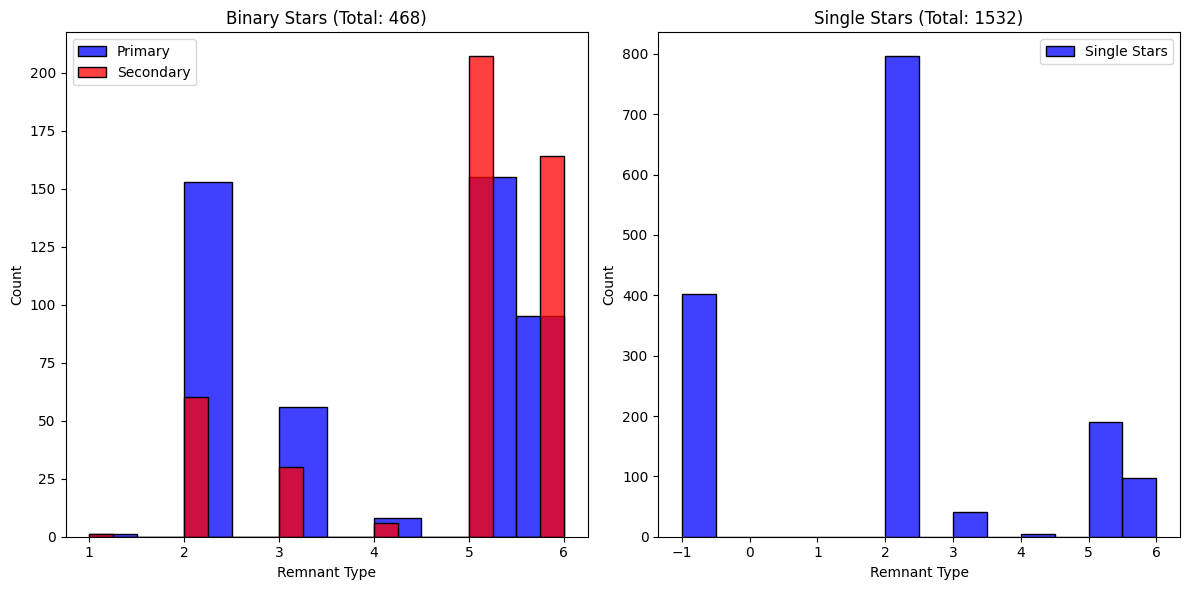

In [11]:
plot_remnant_distributions(popsynth_df)

###### Parallax is a measure of the apparent shift in position of a star due to the Earth's movement around the Sun and is typically measured in milliarcseconds (mas). Not calculated, sampled from a distribution in astromet

### Simulate a **Gaia Observation** with astromet and calculate **RUWE**

- RUWE ≈ 1: The astrometric model (single-star model) fits the data well, meaning that the observed motion and position of the object align with what is expected for a single star.

- RUWE > 1.4: A value higher than 1.4 may indicate a poor fit, suggesting the object could be more complex (e.g., a binary star system, or something else affecting the motion or position).

- Lower values (~1): Generally considered to indicate a good fit.

# Astrometric Parameters

Descriptions of key astrometric parameters used in astronomical observations, such as in the Gaia mission. These parameters describe the position and motion of celestial objects.

## Astrometric Parameters

### 1. Right Ascension (RA) – `params.ra`
Right Ascension (RA) defines the east-west position of an object on the celestial sphere, analogous to longitude on Earth. It is measured in hours, minutes, and seconds, ranging from 0 to 24 hours.

### 2. Declination (Dec) – `params.dec`
Declination (Dec) defines the north-south position of an object on the celestial sphere, analogous to latitude. It is measured in degrees, with values ranging from -90° to +90°, where 0° is the celestial equator.

### 3. Parallax – `params.parallax`
Parallax is the apparent shift in the position of a star due to Earth's motion around the Sun, measured in arcseconds. It is used to determine the distance to nearby stars, where distance (in parsecs) is the inverse of the parallax.

### 4. Proper Motion in RA (PMRA) – `params.pmrac`
Proper Motion in Right Ascension (PMRA) describes a star's east-west motion across the sky, scaled by the cosine of the Declination to account for spherical geometry. It is measured in milliarcseconds per year (mas/yr).

### 5. Proper Motion in Dec (PMDec) – `params.pmdec`
Proper Motion in Declination (PMDec) describes a star's north-south motion across the sky, also measured in milliarcseconds per year (mas/yr).

## Conclusion
These astrometric parameters are essential for mapping the position and motion of celestial objects, helping astronomers understand their dynamics and distances.

In [12]:
nTest=popsynth_df.shape[0]

allData = gaia_observation(nTest, popsynth_df, astromet, Source, dr3_sl, show_plot=False)

100%|██████████| 2000/2000 [05:46<00:00,  5.77it/s] 


In [13]:
df = allData.to_pandas()

In [14]:
# save the data to a csv file
df.to_csv("gaia_data.csv", index=False)

In [15]:
# read the data from the csv file
df = pd.read_csv("gaia_data.csv")

## Plot RUWE vs Metallicity

In [16]:
# Example usage
binary_fraction = 0.1
df_0_1 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.2
df_0_2 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.3
df_0_3 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.4
df_0_4 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.5
df_0_5 = sample_with_binary_fraction(df, binary_fraction)

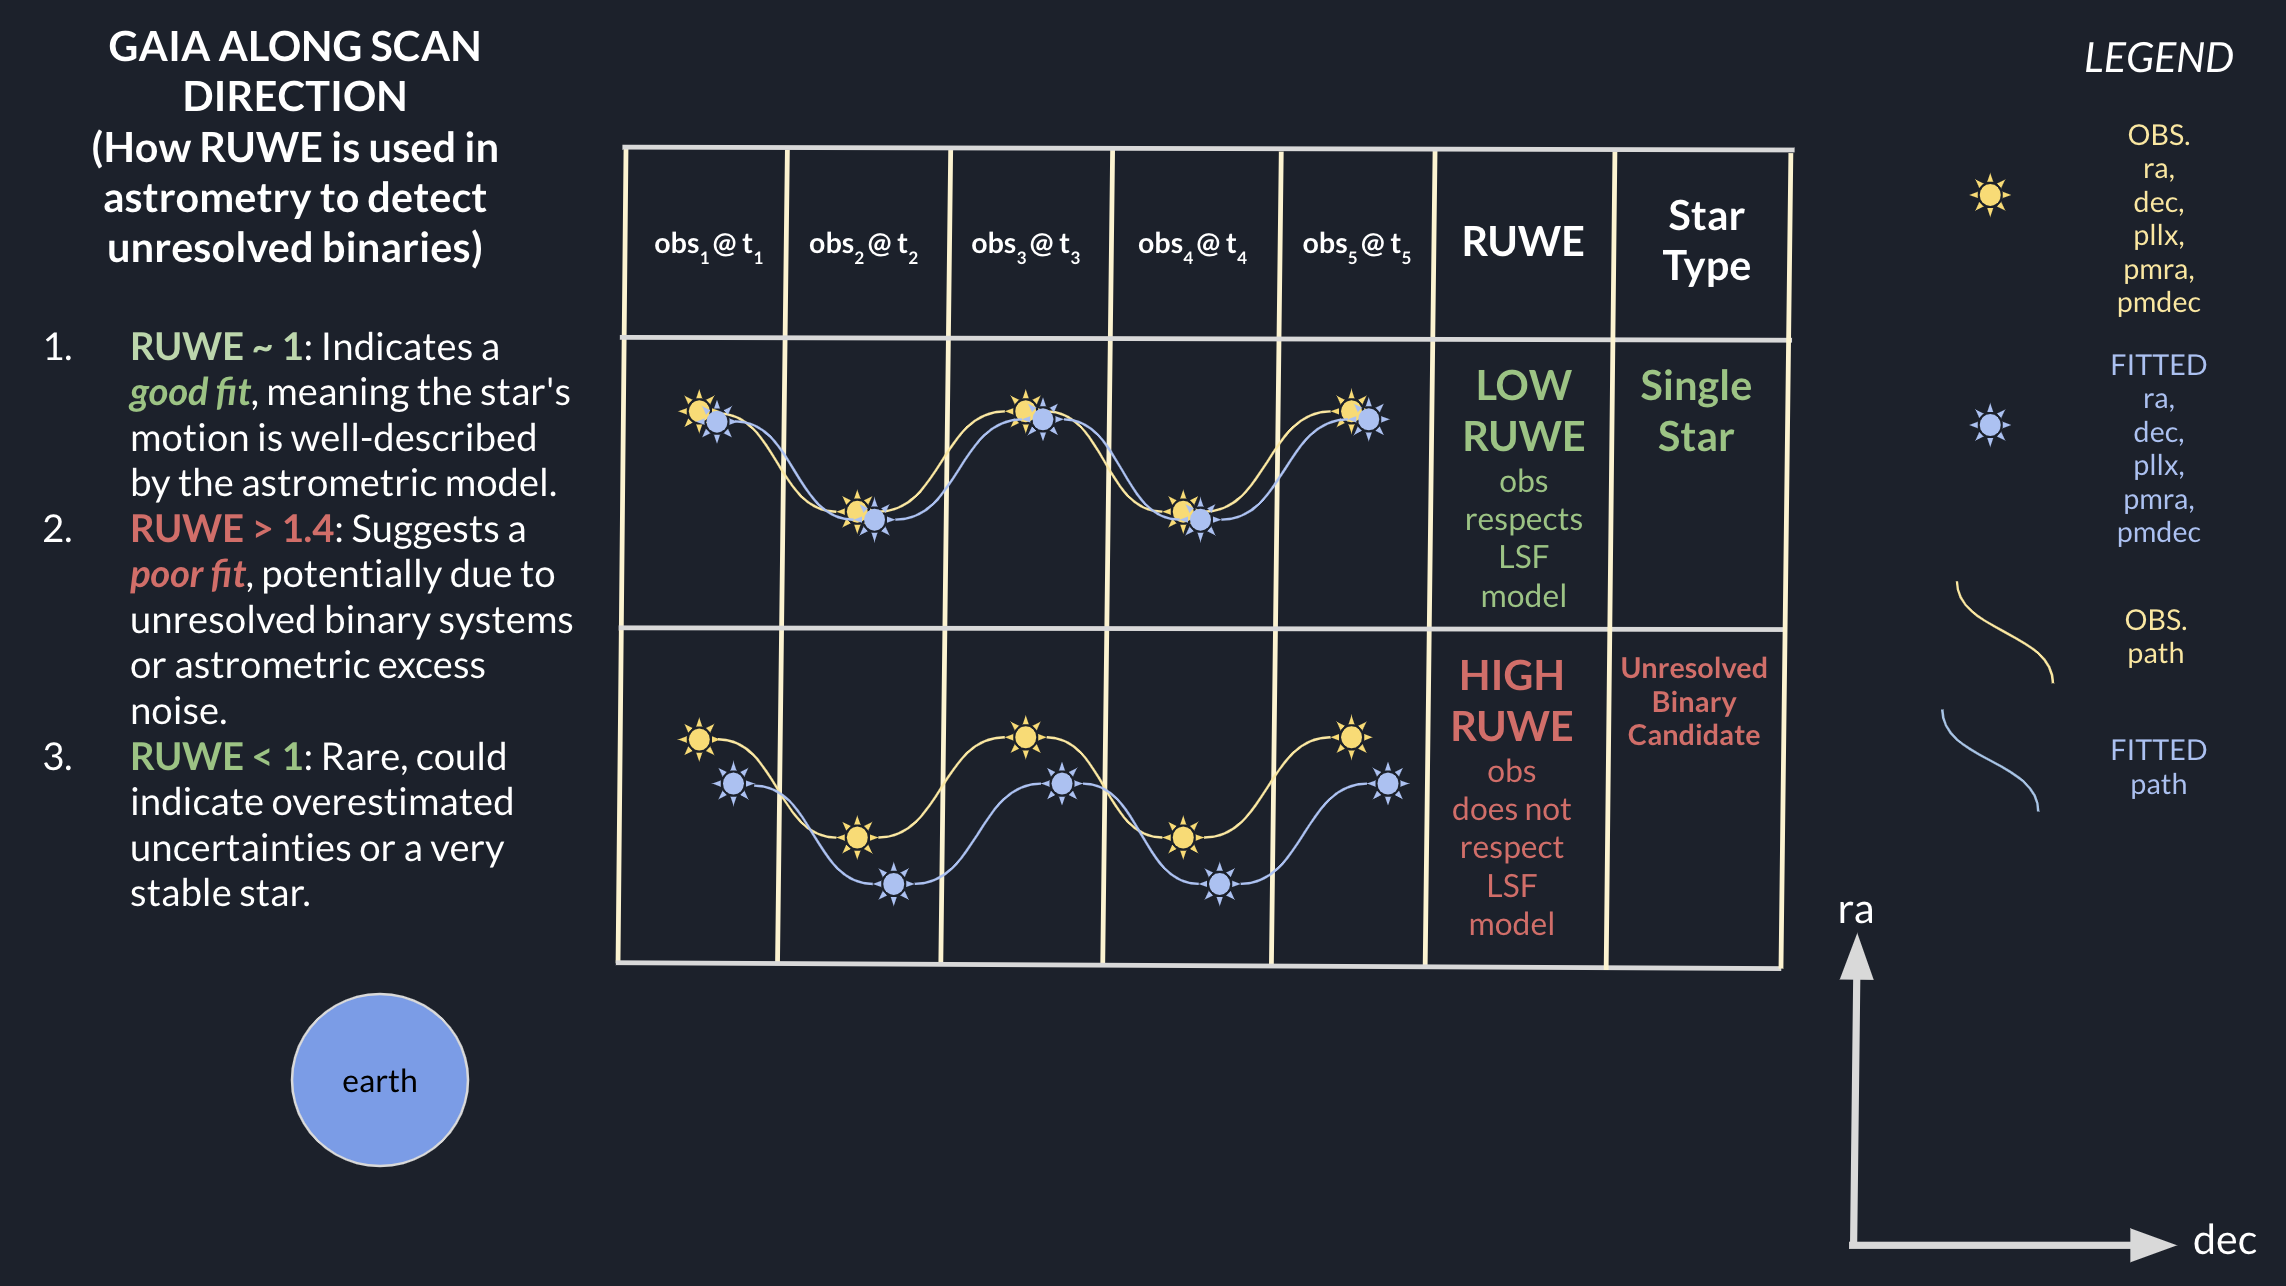

In [43]:
# Display an image from a local file with specified size
img_path = 'images/gaia_ruwe.png'
display(Image(filename=img_path, width=1000, height=800))  # Adjust width and height as needed

Setting the style and context for the plot
Creating the figure and axis objects
Looping over the DataFrames and titles


Plotting distributions:   0%|          | 0/5 [00:00<?, ?it/s]

Plotting KDE for Binary Fraction 0.1


Plotting distributions:  20%|██        | 1/5 [00:00<00:00,  5.44it/s]

KDE for Binary Fraction 0.1 plotted with mean 3.57
Plotting KDE for Binary Fraction 0.2
KDE for Binary Fraction 0.2 plotted with mean 13.98
Plotting KDE for Binary Fraction 0.3


Plotting distributions:  60%|██████    | 3/5 [00:00<00:00, 10.68it/s]

KDE for Binary Fraction 0.3 plotted with mean 17.41
Plotting KDE for Binary Fraction 0.4


Plotting distributions: 100%|██████████| 5/5 [00:00<00:00, 10.02it/s]

KDE for Binary Fraction 0.4 plotted with mean 30.38
Plotting KDE for Binary Fraction 0.5
KDE for Binary Fraction 0.5 plotted with mean 35.58


Setting the x-axis limits
Setting labels and title
Adding a legend
Customizing the grid
Customizing the ticks
Showing the plot


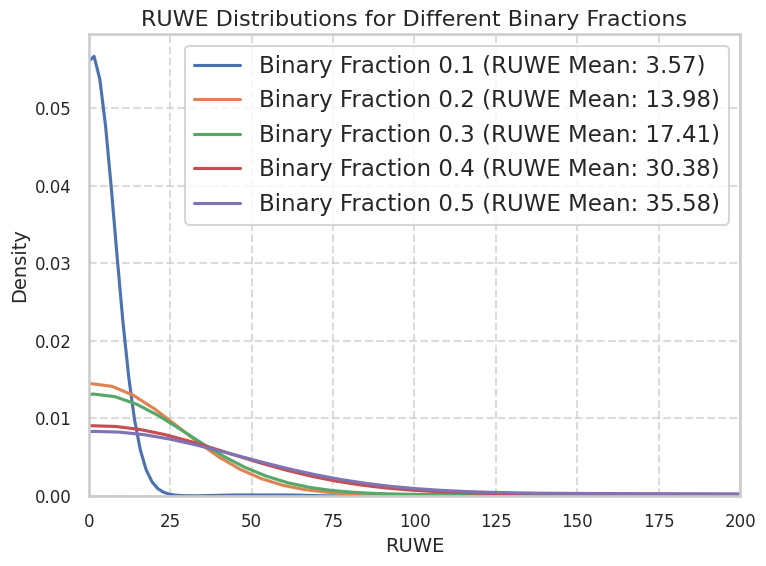

Plot displayed


In [24]:
# Example usage
df_list = [df_0_1, df_0_2, df_0_3, df_0_4, df_0_5]
titles = ['Binary Fraction 0.1', 'Binary Fraction 0.2', 'Binary Fraction 0.3', 'Binary Fraction 0.4', 'Binary Fraction 0.5']
plot_ruwe_distributions(df_list, titles, xlim=(0, 2e2))

# Plot Luminosity vs Temperature

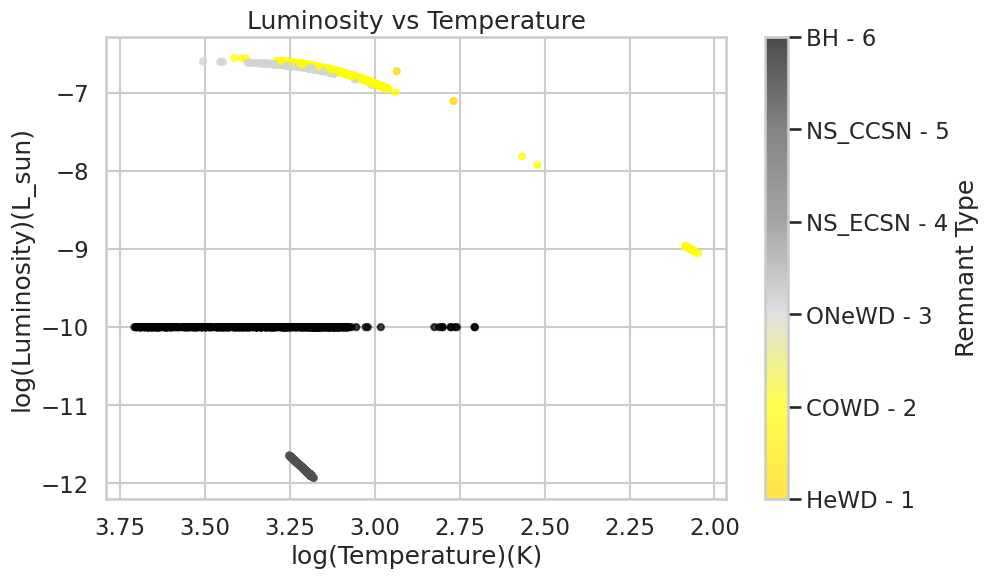

In [42]:
plot_luminosity_vs_temperature(df)

# Notes:

1) Make Ruwe distribution plot over time at various evolution steps 
2) Explore different metallicities
